In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import argparse
import matplotlib.colors as mcolors                   

In [2]:


models = ["GAM"]
taxas = ["Mammals"]


model_names = ['GFDL-ESM2M','IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

species_names = available_names[:100]

In [6]:
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)

In [48]:
ds_hist= xr.open_dataset('/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Mammals/EWEMBI/Equus_africanus_[1146].nc', decode_times=False)

In [58]:
ds_fut= xr.open_dataset('/storage/scratch/users/ch21o450/data/LandClim_Output/GAM/Mammals/IPSL-CM5A-LR/rcp26/Equus_africanus_[35].nc', decode_times=False)

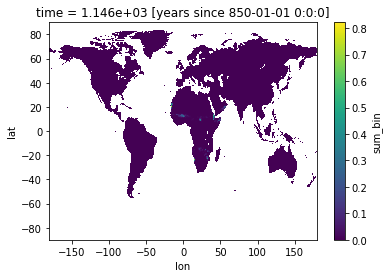

In [60]:
ds_hist.sum_bin.plot()

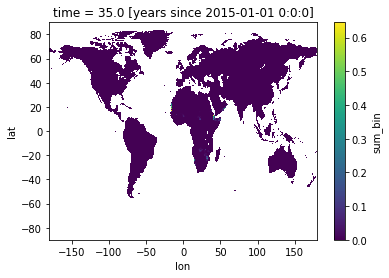

In [61]:
ds_fut.sum_bin.plot()

ValueError: ('lat', 'lon') must be a permuted list of ('variable', 'time', 'lat', 'lon', 'bounds'), unless `...` is included

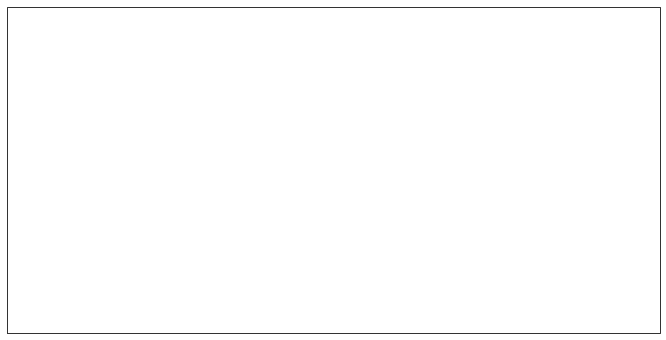

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})


ax = axes
# Compute the difference between da_landuse and da_historic


# Plot data
im = ds_fut.plot.imshow(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap='viridis', ax=ax)

# Set map extent and add borders
ax.set_extent((-20, 60, -40, 40))

In [32]:

models = ["GAM"]
taxas = ["Mammals"]


model_names = ['GFDL-ESM2M','IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

species_names = available_names[:10]
#newvalue
for taxa in taxas:
    for model in models:
        def newvalue_fun(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)

                    newvalue = ds["newvalue"]
                    sum_bin = ds["sum_bin"]

                    newvalue_dict[model_name][species_name] = newvalue
                    sum_bin_dict[model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model_name in model_names:
                    value_bin = newvalue_dict[model_name][species_name]
                    #value_bin = value_bin.where(value_bin > 0, 1)
                    value_bin = (value_bin > 0.05)
                    
                    value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").sum(dim="species")
            mean_value_bin = mean_value_bin.where(mean_value_bin > 0, 0)
            return mean_value_bin

        def calculate_mean(time, model, netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model_name: {} for model_name in model_names}
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]

                    sum_bin = (sum_bin > 0.5)

                    sum_bin_dict[model_name][species_name] = sum_bin

            
            projections_dict = {}

            for species_name in species_names:
                sum_bin_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    sum_bin_list.append(sum_bin)
                sum_bin_concat = xr.concat(sum_bin_list, dim="model")
                mean_sum_bin = sum_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_sum_bin

            mean_sum_bin_list = list(projections_dict.values())
            mean_sum_bin = xr.concat(mean_sum_bin_list, dim="species").sum(dim="species")
            mean_sum_bin = mean_sum_bin.where(mean_sum_bin > 0, 0)

            return mean_sum_bin

        historical_time = 1146
        future_times = [35, 65, 85]
        scenarios = ["rcp26"]
        model_names = ['GFDL-ESM2M','IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
        netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"

        mean_value_bin_hist = newvalue_fun(historical_time, model, netcdf_path_format_hist, is_historical=True)
        mean_sum_bin_hist = calculate_mean(historical_time, model, netcdf_path_format_hist, is_historical=True)

In [83]:
###tests#### 
time=[85]
models = ["GAM"]
taxas=["Mammals"]
scenarios=["rcp26"]

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]
    ssprcps_shorts = ["ssp126","ssp460"]
elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]
    ssprcps_shorts = ["ssp126"]
    
#combinations = list(itertools.product(models, model_names))

for taxa in taxas:# Get all possible combinations of models and model_names    
    for model in models :
        for i in range(len(GCMs)):  # Iterate over the range of GCMs length
            GCM = GCMs[i]
            bioscen_GCM = bioscen_GCMs[i]
            print("GCM", GCM)
            for scenario in scenarios:
                print ("Scneario", scenario)
                for l, ssprcp_short in enumerate(ssprcps_shorts):

                    convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                    dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                    dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                    available_file = os.listdir(dir_species)
                    available_names = ['Equus_africanus_GAM_dispersal']

                    formatted_names = []

                    for species_name in available_names:
                        split_species_name = species_name.split("_")[:2]
                        formatted_species_name = " ".join(split_species_name)
                        formatted_names.append(formatted_species_name)

                    results = []
                    for i, species_name in enumerate(formatted_names[:10]):
                        formatted_species_name = species_name.replace(" ", "_")

                        for file_name in available_file:
                            if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                                species_file = file_name
                                species_file2 = [x.split(".csv")[0] for x in species_file] 
                                break
                        else:
                            bioscen_species = None
                            continue
                            

                        bioscen_species = pd.read_csv(dir_species + file_name)

                        available_files_iucn = formatted_species_name + ".csv"
                        if available_files_iucn in os.listdir(dir_habclass):
                            IUCN = pd.read_csv(dir_habclass + available_files_iucn)
                        else:
                            continue

                        lon = bioscen_species["x"]
                        lat = bioscen_species["y"]
                        z = bioscen_species[bioscen_GCM + '_' + scenario + '_' + selected_year]

                        df = pd.DataFrame({"lon": lon, "lat": lat, "vals": z})
                        df = df.fillna(0)
                        convcodes_renamed = convcodes.rename(columns={'IUCN_hab':'result.code'})
                        Habitats = IUCN.merge(convcodes_renamed, left_on='result.code', right_on='result.code')

                        keys = ['LUH1', 'LUH2', 'LUH3', 'LUH4', 'LUH5', 'LUH6', 'LUH7', 'LUH8','LUH9','LUH10', 'LUH11', 'LUH12']
                        split_cols = Habitats['LUH'].str.split('.', expand=True)
                        for i, key in enumerate(keys):
                            if i < len(split_cols.columns):
                                Habitats[key] = split_cols[i]
                            else:
                                Habitats[key] = pd.Series(dtype='float64')
                        if len(Habitats.columns) > len(keys) + 1:
                            num_missing_cols = len(Habitats.columns) - len(keys) - 1
                            Habitats = Habitats.reindex(columns=list(Habitats.columns) + ['LUH{}'.format(i) for i in range(13, 13 + num_missing_cols)], fill_value=np.nan)
                            Habitats.drop('LUH', axis=1, inplace=True)
                        Habitats_suitable = Habitats[Habitats['result.suitability'] == 'Suitable'].copy()

                        LandUseList = "/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_" + ssprcps_shorts[l] + ".nc"

                        #isimip = xr.open_dataarray("/storage/workspaces/wa_climate/climate_trt/data/ISIMIP/ISIMIP3b/InputData/GCM/global/miroc6_r1i1p1f1_w5e5_ssp585_tasmin_global_daily_2071_2080.nc")


                        ncfname = LandUseList
                        da_landuse =  xr.open_dataset(ncfname, decode_times=False)
                        da_landuse = da_landuse.isel(time=time)

                        #prifdf_bin = xr.where(prifdf > 0, 1, 0)
                        df_sdm =df

                        #build an empty np.array 
                        np_empty = np.zeros_like(da_landuse['primf'].values, dtype=float)

                        #isimip_lats = isimip['lat'].values
                        #isimip_lons = isimip['lon'].values

                        lats = da_landuse['lat'].values
                        lons = da_landuse['lon'].values

                        da_empty = xr.DataArray(np_empty, coords=[time, lats, lons], dims=['time','lats','lons'])
                        da_landclim = da_empty.assign_attrs(da_landuse)

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame

                        # Compute the product with the "newvalue" column and assign it to a new column in the merged DataFrame
                        latitudes = df_sdm['lat'].unique()
                        longitudes = df_sdm['lon'].unique()

                        lats_sorted = np.sort(latitudes)
                        lons_sorted = np.sort(longitudes)

                       # Create a dictionary with (lat, lon) tuples as keys and the corresponding values from df_sdm as values
                        sdm_dict = {(lat, lon): vals for lat, lon, vals in df_sdm[['lat', 'lon', 'vals']].to_numpy()}

                        # Initialize the newvalue_array with NaNs instead of zeros
                        newvalue_array = np.full((len(lats_sorted), len(lons_sorted)), np.nan)

                        # Loop over the latitudes and longitudes and use the dictionary to perform the lookup
                        for i, lat in enumerate(lats_sorted):
                            for j, lon in enumerate(lons_sorted):
                                vals = sdm_dict.get((lat, lon), np.nan)
                                if not np.isnan(vals):
                                    newvalue_array[i, j] = vals


                        da = xr.DataArray(newvalue_array, coords=[lats_sorted, lons_sorted], dims=['lat', 'lon'])
                        # Interpolate the values of newvalue to the dimensions of A
                        interpolated_values = da.interp(lat=lats, lon=lons)

                        # Add the interpolated values to the A DataArray
                        da_landuse['newvalue'] = interpolated_values
                        da_landuse['newvalue'] = interpolated_values.fillna(0)


                        keys = [row[f"LUH{i}"] for _, row in Habitats_suitable.iterrows() for i in range(1, 5) if pd.notna(row[f"LUH{i}"])]

                        keys = list(set(keys))

                        num_codes = 0
                        for code in keys: 
                            # Check if the code is "MARINE" and skip land-use filter if it is
                            if code == "MARINE":
                                pass
                            else:
                                num_codes += 1
                                # Compute the product with the LUH code and the "newvalue" column, and assign it to a new column in the merged DataFrame
                                np_empty = np.zeros_like(da_landuse[code].values, dtype=float)
                                da_landuse[f"{code}_bin"] = da_landuse[code] * da_landuse["newvalue"]

                                da_landuse[f"{code}_binary"] = (da_landuse[code] > 0).astype(float)
                                da_landuse[f"{code}_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue"]

                                da_landuse["newvalue_binary"] = (da_landuse["newvalue"] >0).astype(float)
                                da_landuse[f"{code}_poo_lu_binary"] = da_landuse[f"{code}_binary"] * da_landuse["newvalue_binary"]
                                # Select the DataArrays ending in "_bin"
                                bin_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_bin") and var != "sum_bin"]
                                binary_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_lu_binary") and var != "sum_lu_binary"]
                                binary_poo_lu_arrays = [da_landuse[var] for var in da_landuse.data_vars if var.endswith("_poo_lu_binary") and var != "sum_poo_lu_binary"]

                                # Multiply all the arrays together
                                sum_bin = reduce(lambda x, y: x + y, bin_arrays)
                                sum_lu_binary = reduce(lambda x, y: x + y, binary_arrays)
                                sum_poo_lu_binary = reduce(lambda x, y: x + y, binary_poo_lu_arrays)

                                # Assign the "product_bin" attribute to the da_landuse DataArray
                                da_landuse["sum_bin"] = sum_bin
                                da_landuse["sum_lu_binary"] = sum_lu_binary
                                da_landuse["sum_poo_lu_binary"] = sum_poo_lu_binary
                                da_landuse["sum_poo_lu_binary_norm"] = da_landuse["sum_poo_lu_binary"] / num_codes

                                difference = da_landuse["sum_bin"] - da_landuse["newvalue"]
                                da_landuse["difference_filter"] = difference

                                da_landclim = da_landclim.assign_attrs(da_landuse)

                                output_directory = "/storage/scratch/users/ch21o450/data/test/" + model+ "/" + taxa + "/" + GCM + "/" + scenario + "/"
                                os.makedirs(output_directory, exist_ok=True)



                       # Create a new column with binary values (0 or 1) based on the condition if landuse[code] is greater than 0





GCM IPSL-CM5A-LR
Scneario rcp26
GCM HadGEM2-ES
Scneario rcp26
GCM MIROC5
Scneario rcp26


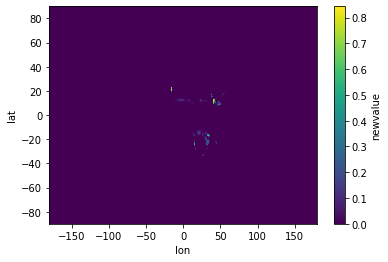

In [84]:
da_landuse['newvalue'].plot()

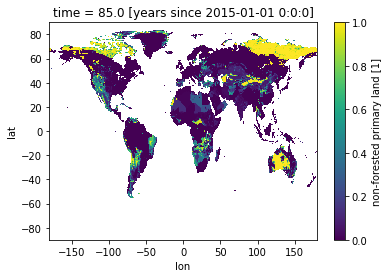

In [85]:
da_landuse['primn'].plot()

In [88]:
test= da_landuse['newvalue'] * da_landuse['primn'] + da_landuse['newvalue'] * da_landuse['secdn']

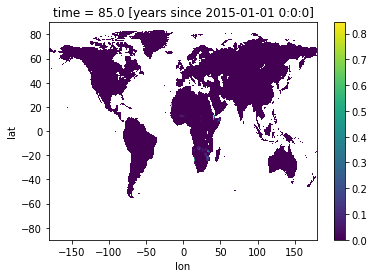

In [90]:
test.plot()

In [87]:
da_landuse['secdn'].mean()

<xarray.DataArray 'secdn' ()>
array(0.13333495, dtype=float32)

In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings
years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:10]

   
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            newvalue_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}
            
            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        newvalue = ds["newvalue"]
                        sum_bin = ds["sum_bin"]

                        newvalue_dict[model][model_name][species_name] = newvalue
                        sum_bin_dict[model][model_name][species_name] = sum_bin

                projections_dict = {}

            for species_name in species_names:
                value_list = []
                for model in models:
                    for model_name in model_names:
                        value_bin = newvalue_dict[model][model_name][species_name]
                        value_list.append(value_bin)
                value_bin_concat = xr.concat(value_list, dim="model")
                mean_value_bin = value_bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_value_bin

            value_bin_list = list(projections_dict.values())
            mean_value_bin = xr.concat(value_bin_list, dim="species").mean(dim="species")

            return mean_value_bin

future_times = [35, 65, 85]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        # Call both functions and unpack their return values
        mean_value_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)

        im = ax1.pcolormesh(mean_value_bin_gam['lon'].values, mean_value_bin_gam['lat'].values, np.where(mean_value_bin_gam.values != 0, mean_value_bin_gam.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1])
        tick_labels = [str(int(tick)) for tick in ticks_b]
        cbar =  plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)

        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1



NameError: name 'taxas' is not defined

In [107]:
mean_bin_gam

<xarray.DataArray 'sum_bin' (time: 1, lat: 360, lon: 720)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) float64 35.0
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75

/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/storage/homefs/ch21o450/.local/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


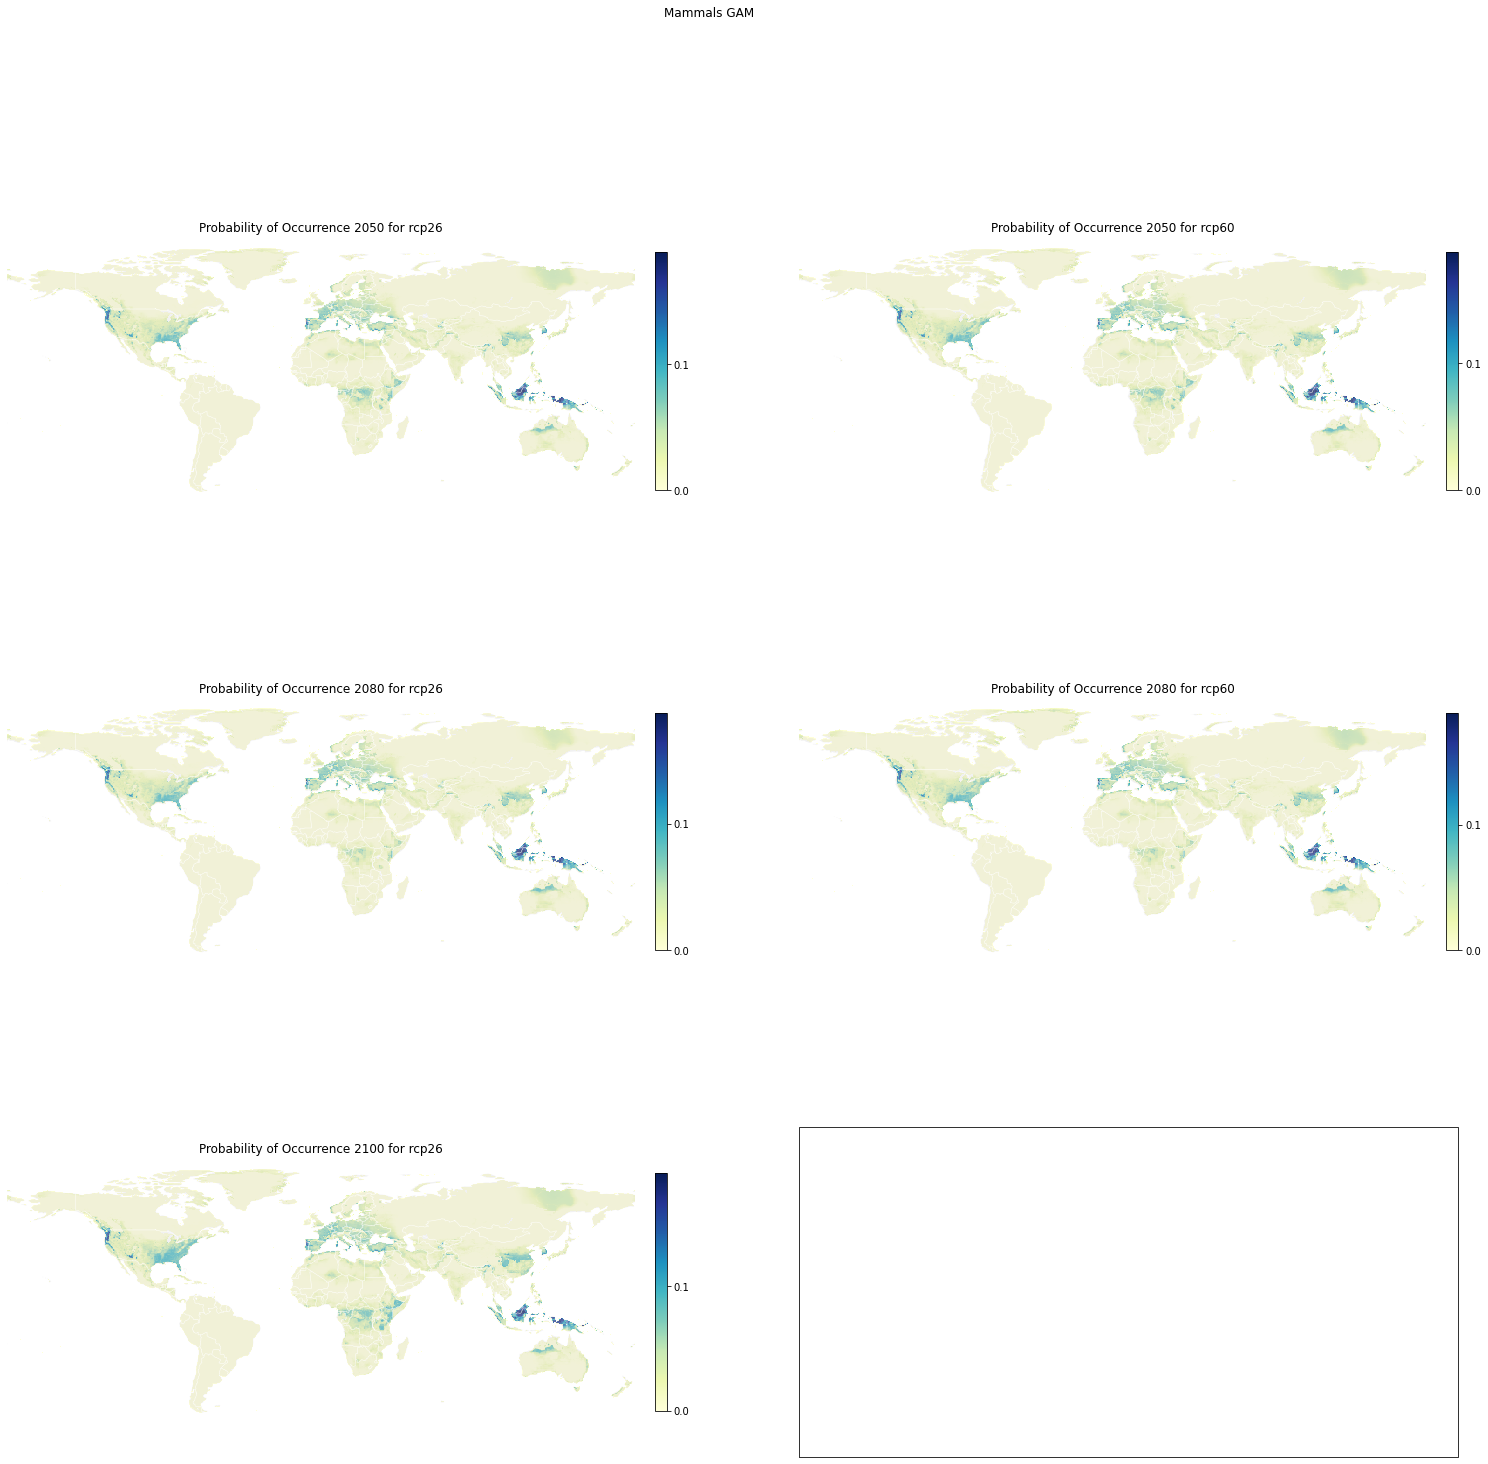

In [116]:
model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
#model_names = ['GFDL-ESM2M']

years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050', 
                 '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]


        species_names = available_names[:10]

   
        
        def newvalue_fun(time, model, model_names,netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model: {model_name: {} for model_name in model_names} for model in models}

            for model in models:
                for model_name in model_names:
                    for species_name in species_names:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                        sum_bin = ds["sum_bin"]
                        sum_bin_dict[model][model_name][species_name] = sum_bin

            projections_dict = {}

            for species_name in species_names:
                bin_list = []
                for model in models:
                    for model_name in model_names:
                        sum_bin = sum_bin_dict[model][model_name][species_name]
                        bin_list.append(sum_bin)
                bin_concat = xr.concat(bin_list, dim="model")
                mean_bin = bin_concat.mean(dim="model")
                projections_dict[species_name] = mean_bin

            bin_list = list(projections_dict.values())
            mean_bin = xr.concat(bin_list, dim="species").mean(dim="species")

            return mean_bin

future_times = [35, 65, 85]

netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(26, 24), subplot_kw={'projection': ccrs.PlateCarree()})


cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(
              gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

for future_time in future_times:
    if future_time == 35 or future_time == 65:
        model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26","rcp60"]
    elif future_time == 85:
        model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
        scenarios = ["rcp26"]
    for scenario in scenarios:
        if future_time == 85 and scenario == "rcp60":
            continue

        # Call both functions and unpack their return values
        mean_bin_gam = newvalue_fun(future_time, ["GAM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        #mean_value_bin_gbm = newvalue_fun(future_time, ["GBM"], model_names, netcdf_path_format_future, is_historical=False, scenario=scenario)
        # Calculate the difference between the two
        # diff_bin = mean_sum_bin -mean_value_bin

        # Create three subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        #ax2 = axes.flatten()[plot_idx + 1]


        # Plotting code starts here
        cmap = plt.colormaps['YlGnBu']
        boundaries = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1] # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)
        mean_bin_gam = mean_bin_gam.isel(time=0)
        im = mean_bin_gam.plot.imshow(x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmap, ax=ax1, add_colorbar=False)
        #im = ax1.pcolormesh(mean_bin_gam['lon'].values, mean_bin_gam['lat'].values, mean_bin_gam.values, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Probability of Occurrence {year_indices[future_time]} for {scenario}")



        ax1.axis('off')
        ax1.set_extent((-180,180,-63,90))
        ax1.add_feature(cfeature.BORDERS,color='white',linewidth=0.5)

        ticks_b = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
        tick_labels = [str(int(tick)) for tick in ticks_b]
        cbar =  plt.colorbar(im, ax=ax1, fraction=0.018, pad=0.03, spacing='proportional', ticks=ticks_b)

        # Increase the plot index by 2 to move to the next pair of subplots
        plt.suptitle(taxa + " " + model)
        plot_idx += 1